In [17]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
%matplotlib inline

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf
from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32
from scipy.stats import multivariate_normal
import math, sys, os, pickle
from record import Record, affiche_records
import time

In [ ]:
#del dict_records
#nom_fic = 'backbone-CNN-parts-base'
nom_fic = 'base-base'

#dict_records = np.load('mnist-waveimage-records-FEP-dual-full-limit.npy').tolist()
dict_records = np.load('mnist-waveimage-records-H0_init-'+nom_fic+'.npy').tolist()
'''dict_records_bis = np.load('mnist-waveimage-records-FEP-dual-full-H0_init-random.npy').tolist()
for k in dict_records_bis:
    dict_records[k] = {}
    for k2 in dict_records_bis[k]:
        dict_records[k][k2]  = dict_records_bis[k][k2]'''
#dict_records = np.load('mnist-waveimage-records-FEP-dual-full-H0_init-naive-bayes.npy').tolist()
#dict_records = np.load('tmp.npy').tolist() # +++
#dict_records = np.load('data/mnist-waveimage-FCNN-records-predictive-1e-05.npy').tolist()
#dict_records = np.load('mnist-waveimage-CNN-backbone-records-predictive.npy').tolist()
#dict_records = np.load('mnist-waveimage-CNN-backbone-records-rnd-parts-FEP-dual-H0_init.npy').tolist()
'''dict_records = np.load('mnist-waveimage-CNN-backbone-records-rnd-parts.npy').tolist()
dict_records_bis = np.load('mnist-waveimage-CNN-backbone-records-rnd-parts-saliency.npy').tolist()
dict_records_bis = np.load('mnist-waveimage-records-FEP-dual.npy').tolist()
for k in dict_records_bis:
    dict_records[k] = {}
    for k2 in dict_records_bis[k]:
        dict_records[k][k2]  = dict_records_bis[k][k2]
dict_records_ter = np.load('mnist-waveimage-CNN-backbone-records-rnd-parts-generic-saliency.npy').tolist()
for k in dict_records_ter:
    dict_records[k] = {}
    for k2 in dict_records_ter[k]:
        dict_records[k][k2]  = dict_records_ter[k][k2]
dict_records_quad = np.load('mnist-waveimage-CNN-backbone-records-rnd-parts-FEP-full-dual.npy').tolist()
for k in dict_records_quad:
    dict_records[k] = {}
    for k2 in dict_records_quad[k]:
        dict_records[k][k2]  = dict_records_quad[k][k2]
dict_records_quint = np.load('mnist-waveimage-CNN-backbone-records-rnd-parts-FEP-dual.npy').tolist()
for k in dict_records_quint:
    dict_records[k] = {}
    for k2 in dict_records_quint[k]:
        dict_records[k][k2]  = dict_records_quint[k][k2]'''


In [ ]:
NB_CLASSES = 10
NB_TRIALS = 100

In [ ]:
liste_NB_TRIALS = []
for z in range(NB_CLASSES):
    liste_NB_TRIALS += [NB_TRIALS] #[len(Data_test[z][0][(0,0)])]

mem_classif_rate = {}
mem_mem_saccades = {}
mem_mem_compression_rate = {}

'''liste_pol  = ('smooth-predictive-IG-post',)'''

liste_pol  = (\
            'smooth-predictive-Info-Gain', 'smooth-predictive-Infomax', \
            'smooth-predictive-Innovation', 'smooth-predictive-Conservation', 'smooth-predictive-IG-post', \
            'saliency-based', 'generic-saliency-based', 'random', \
            #'full', \
            'sharp-predictive-Info-Gain', 'sharp-predictive-Infomax', \
            'sharp-predictive-Innovation', 'sharp-predictive-Conservation', 'sharp-predictive-IG-post',\
             )

#for POL in ('predictive', 'predictive-dual', 'predictive-KL', 'FEP-predictive', 'FEP-predictive-dual', 'FEP-predictive-KL',  'saliency-based', 'generic-saliency-based', 'random'): #): #: #', ' ):
for POL in liste_pol:
    mem_classif_rate[POL] = []
    mem_mem_saccades[POL] = []
    mem_mem_compression_rate[POL] = []
    
    #for THRESHOLD in (2, 1.5, 1, 7e-1, 5e-1, 3e-1, 2e-1, 1e-1):#
    for THRESHOLD in (1e-1, 1e-2, 1e-3, 1e-4): #, 1e-5):
    #for THRESHOLD in (1, 3e-1, 1e-1, 3e-2, 1e-2): # 1e-4): #, 1e-5):
        classif_rate, mem_saccades, mem_compression_rate = affiche_records(dict_records[POL][THRESHOLD], liste_NB_TRIALS)
        mem_classif_rate[POL] += [classif_rate]
        mem_mem_saccades[POL] += [mem_saccades]
        mem_mem_compression_rate[POL] += [mem_compression_rate]

Policy : predictive-dual
Threshold : 1
classif rate : 61.6
nb_saccades : 4.125
nb_coeffs : 47.643
compression rate : 93.9230867347
final posterior : 0.796156613211
final entropy : 0.667606989425


Policy : predictive-dual
Threshold : 0.7
classif rate : 67.8
nb_saccades : 7.825
nb_coeffs : 70.02
compression rate : 91.068877551
final posterior : 0.876600975014
final entropy : 0.455195535209


Policy : predictive-dual
Threshold : 0.5
classif rate : 70.0
nb_saccades : 13.705
nb_coeffs : 97.323
compression rate : 87.5863520408
final posterior : 0.916586927384
final entropy : 0.332730806813


Policy : predictive-dual
Threshold : 0.3
classif rate : 70.6
nb_saccades : 34.809
nb_coeffs : 182.721
compression rate : 76.69375
final posterior : 0.934196505437
final entropy : 0.241143779973


Policy : predictive-dual
Threshold : 0.2
classif rate : 69.9
nb_saccades : 43.896
nb_coeffs : 219.471
compression rate : 72.00625
final posterior : 0.946281379985
final entropy : 0.187797088061

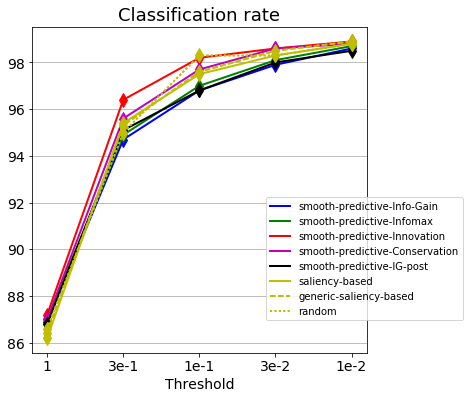

In [12]:
f = plt.figure(figsize = (6, 6))
NB_THRESHOLDS = 5
liste_col = ['b', 'g', 'r','m','k','y','y--', 'y:']

for i, POL in enumerate(liste_pol[:8]):
    plt.plot(np.arange(NB_THRESHOLDS), mem_classif_rate[POL], liste_col[i], label = liste_pol[i], lw=2)
    plt.plot(np.arange(NB_THRESHOLDS), mem_classif_rate[POL], liste_col[i]+'d', ms = 10)
#plt.plot([-.1,4.1], [mem_classif_rate['full'][0]] * 2, 'r--', label = 'exhaustive scan', lw=2)
plt.legend(loc = (.7,.1))
plt.title('Classification rate', fontsize = 18)
plt.xlabel('Threshold', fontsize = 14)
#plt.xticks(np.arange(NB_THRESHOLDS), ('1e-1', '1e-2', '1e-3', '1e-4', '1e-5'), fontsize = 14)
plt.xticks(np.arange(NB_THRESHOLDS), ('1', '3e-1', '1e-1', '3e-2', '1e-2'), fontsize = 14)
#plt.xticks(np.arange(NB_THRESHOLDS), ('2', '1.5', '1', '7e-1', '5e-1', '3e-1', '2e-1', '1e-1'), fontsize = 14)
plt.yticks(fontsize = 14)
#plt.xlim([-.2,4.2])
#plt.ylim([70, 100])
f.gca().yaxis.grid(True)
#plt.savefig('FEP-CNN-classif.png')
plt.savefig('FEP-base-classif-IMOL-9.png')



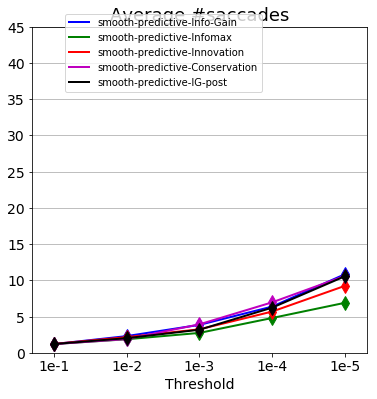

In [14]:
plt.figure(figsize = (6, 6))
axe = plt.subplot(1,1,1)
liste_col = ['b', 'g', 'r','m','k','y','y--', 'y:']
#liste_pol = ['H1-FEP', 'Dual-FEP', 'Infomax',  'Random']
#liste_pol =  ['IG', 'Infomax + BS', 'Infomax',  'Random']

for i, POL in enumerate(liste_pol[:5]):
    plt.plot(np.arange(NB_THRESHOLDS), np.mean(np.array(mem_mem_saccades[POL]), 1), liste_col[i], label = liste_pol[i], lw = 2)
    plt.plot(np.arange(NB_THRESHOLDS), np.mean(np.array(mem_mem_saccades[POL]), 1), liste_col[i]+'d', ms = 10)
    '''asymmetric_error = [np.zeros(5), np.std(np.array(mem_mem_saccades[POL]), 1)]
    plt.errorbar(np.arange(5) + .02 * (i - 1), \
                 np.mean(np.array(mem_mem_saccades[POL]), 1), \
                 yerr = asymmetric_error, \
                 marker = '', \
                 color = liste_col[i],
                 linestyle = 'None')'''
plt.legend(loc = (.1,.8))
plt.title('Average #saccades', fontsize = 18)
plt.xlabel('Threshold', fontsize = 14)
plt.xticks(np.arange(5), ('1e-1', '1e-2', '1e-3', '1e-4', '1e-5'), fontsize = 14)
#plt.xticks(np.arange(NB_THRESHOLDS), ('1', '3e-1', '1e-1', '3e-2', '1e-2'), fontsize = 14)
plt.yticks(fontsize = 14)
#plt.xlim([-.2,4.2])
plt.xlim([-.3,4.3])
axe.yaxis.grid(True)
plt.ylim([0, 45])    
#axe.set_yscale('log')
plt.savefig('FEP-base-saccades-IMOL-9.png')




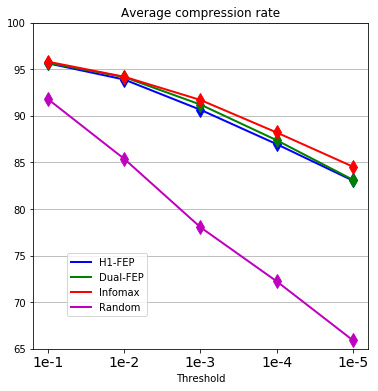

In [47]:
f = plt.figure(figsize = (6, 6))

axe = plt.subplot(1,1,1)
liste_col = ['b', 'g', 'r','m']
liste_pol = ['H1-FEP', 'Dual-FEP', 'Infomax',  'Random']
for i, POL in enumerate(('FEP-predictive-KL', 'FEP-predictive-dual', 'FEP-predictive',  'random')):
    plt.plot(np.arange(NB_THRESHOLDS), np.mean(np.array(mem_mem_compression_rate[POL]), 1), \
             liste_col[i], label = liste_pol[i], lw = 2)
    plt.plot(np.arange(NB_THRESHOLDS), np.mean(np.array(mem_mem_compression_rate[POL]), 1), \
             liste_col[i]+'d', ms = 10)
plt.legend(loc = (.1,.1))
plt.title('Average compression rate')
plt.xlabel('Threshold')
plt.xticks(np.arange(NB_THRESHOLDS), ('1e-1', '1e-2', '1e-3', '1e-4', '1e-5'), fontsize = 14)
#plt.xticks(np.arange(NB_THRESHOLDS), ('1', '3e-1', '1e-1', '3e-2', '1e-2'), fontsize = 14)
#plt.xticks(np.arange(NB_THRESHOLDS), ('2', '1.5', '1', '7e-1', '5e-1', '3e-1', '2e-1', '1e-1'), fontsize = 14)
#plt.xlim([-.2,4.2])
plt.ylim([65, 100])
axe.yaxis.grid(True)

plt.savefig('FEP-base-compression.png')
